# **Hypothesis Testing**

Joseph Lardie

September 2023

# **Imports**

In [1]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Seaborn
import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt
import plotly

# Scipy
from scipy import stats
from scipy.stats import norm, pearsonr
import statsmodels.api as sm

# Warnings
import warnings
warnings.filterwarnings("ignore")

## **Loading in datasets**

In [2]:
# Loading NYC Restaraunt Inspection Data
rdf = pd.read_csv('rdf')

In [3]:
# Loading NYC Restaraunt Yelp Review Data
ydf = pd.read_csv('ydf')

In [4]:
# Restaurant Inspection data
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209789 entries, 0 to 209788
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  209789 non-null  int64  
 1   DBA                    209165 non-null  object 
 2   BORO                   209789 non-null  object 
 3   BUILDING               209481 non-null  object 
 4   STREET                 209783 non-null  object 
 5   ZIPCODE                207093 non-null  float64
 6   CUISINE DESCRIPTION    207365 non-null  object 
 7   INSPECTION DATE        209789 non-null  object 
 8   ACTION                 207365 non-null  object 
 9   VIOLATION CODE         206208 non-null  object 
 10  VIOLATION DESCRIPTION  206208 non-null  object 
 11  CRITICAL FLAG          209789 non-null  object 
 12  SCORE                  199793 non-null  float64
 13  GRADE                  102961 non-null  object 
 14  GRADE DATE             94208 non-nul

In [5]:
# Yelp data
ydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   alias         847 non-null    object 
 1   name          847 non-null    object 
 2   image_url     847 non-null    object 
 3   url           847 non-null    object 
 4   review_count  847 non-null    int64  
 5   categories    847 non-null    object 
 6   rating        847 non-null    float64
 7   coordinates   847 non-null    object 
 8   transactions  847 non-null    object 
 9   location      847 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 66.3+ KB


## **Selecting Subset of Pizza Restaurants in Brooklyn**

In [6]:
# Selecting subset of only restaurants from Brooklyn
brooklyndf = rdf[rdf['BORO'].str.lower() == 'brooklyn']

In [7]:
# Selecting subset of only restaurants in Brooklyn that have pizza in the cuisine description
pizza_brooklyn_subset = brooklyndf[(brooklyndf['CUISINE DESCRIPTION'].str.lower() == 'pizza')]

In [8]:
# Filtering out rows with NaN in the 'GRADE' column
pizza_brooklyn_subset = pizza_brooklyn_subset.dropna(subset=['GRADE'])

In [9]:
# Taking a look at Brooklyn pizza restaurants in inspection data
print(pizza_brooklyn_subset)

           CAMIS                     DBA      BORO BUILDING  \
181     40616509               MONTY Q'S  Brooklyn      158   
211     41675367            J-M PIZZA II  Brooklyn     1323   
578     41296556        ENOTECA ON COURT  Brooklyn      347   
668     50047483          LOVE AND DOUGH  Brooklyn       68   
1002    50073372  PINO'S PIZZA AND GRILL  Brooklyn     2025   
...          ...                     ...       ...      ...   
208269  40396492      ROYAL KING'S PIZZA  Brooklyn     5211   
208503  41674167            FRANKS PIZZA  Brooklyn     8025   
209492  50033400        PALACE ON FULTON  Brooklyn     1882   
209504  50140484           MUNDO'S PIZZA  Brooklyn       25   
209771  50041320  A & L PIZZA RESTAURANT  Brooklyn     6024   

                   STREET  ZIPCODE CUISINE DESCRIPTION INSPECTION DATE  \
181       MONTAGUE STREET  11201.0               Pizza      07/19/2022   
211              AVENUE U  11229.0               Pizza      01/06/2022   
578          COURT ST

## **Merging Yelp data with Inspections Data**

In [10]:
# Making the names of the restaurants in both data sets compatable for the merge
column_name = 'name'
# Matching up the names for both datasets
ydf['name'] = ydf['name'].apply(lambda x: str(x).upper())

In [11]:
# Merging the two data sets on the names of the restaurants 
merged_df = pd.merge(pizza_brooklyn_subset, ydf, left_on='DBA', right_on='name', how='inner', indicator=True)

# Dropping any Duplicate rows
merged_df.drop_duplicates(inplace=True)

# Displaying the merged dataframe
print("\nMerged DataFrame:")
print(merged_df)


Merged DataFrame:
        CAMIS                          DBA      BORO BUILDING  \
0    40616509                    MONTY Q'S  Brooklyn      158   
1    40616509                    MONTY Q'S  Brooklyn      158   
2    40616509                    MONTY Q'S  Brooklyn      158   
3    40616509                    MONTY Q'S  Brooklyn      158   
4    40616509                    MONTY Q'S  Brooklyn      158   
..        ...                          ...       ...      ...   
510  40745618                 MIKE'S PIZZA  Brooklyn      905   
512  40745618                 MIKE'S PIZZA  Brooklyn      905   
513  50088788  L'ARTE DELLA PIZZA BROOKLYN  Brooklyn      172   
514  50088788  L'ARTE DELLA PIZZA BROOKLYN  Brooklyn      172   
515  50000967                      WHEATED  Brooklyn      905   

              STREET  ZIPCODE CUISINE DESCRIPTION INSPECTION DATE  \
0    MONTAGUE STREET  11201.0               Pizza      07/19/2022   
1    MONTAGUE STREET  11201.0               Pizza      07/19/2

In [12]:
merged_df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,...,name,image_url,url,review_count,categories,rating,coordinates,transactions,location,_merge
0,40616509,MONTY Q'S,Brooklyn,158,MONTAGUE STREET,11201.0,Pizza,07/19/2022,Violations were cited in the following area(s).,04M,...,MONTY Q'S,https://s3-media2.fl.yelpcdn.com/bphoto/Bse0Uf...,https://www.yelp.com/biz/monty-qs-brooklyn-2?a...,250,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",3.0,"{'latitude': 40.6942, 'longitude': -73.99299}","['delivery', 'pickup']","{'address1': '158 Montague St', 'address2': ''...",both
1,40616509,MONTY Q'S,Brooklyn,158,MONTAGUE STREET,11201.0,Pizza,07/19/2022,Violations were cited in the following area(s).,08A,...,MONTY Q'S,https://s3-media2.fl.yelpcdn.com/bphoto/Bse0Uf...,https://www.yelp.com/biz/monty-qs-brooklyn-2?a...,250,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",3.0,"{'latitude': 40.6942, 'longitude': -73.99299}","['delivery', 'pickup']","{'address1': '158 Montague St', 'address2': ''...",both
2,40616509,MONTY Q'S,Brooklyn,158,MONTAGUE STREET,11201.0,Pizza,10/30/2023,Violations were cited in the following area(s).,10F,...,MONTY Q'S,https://s3-media2.fl.yelpcdn.com/bphoto/Bse0Uf...,https://www.yelp.com/biz/monty-qs-brooklyn-2?a...,250,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",3.0,"{'latitude': 40.6942, 'longitude': -73.99299}","['delivery', 'pickup']","{'address1': '158 Montague St', 'address2': ''...",both
3,40616509,MONTY Q'S,Brooklyn,158,MONTAGUE STREET,11201.0,Pizza,10/30/2023,Violations were cited in the following area(s).,08A,...,MONTY Q'S,https://s3-media2.fl.yelpcdn.com/bphoto/Bse0Uf...,https://www.yelp.com/biz/monty-qs-brooklyn-2?a...,250,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",3.0,"{'latitude': 40.6942, 'longitude': -73.99299}","['delivery', 'pickup']","{'address1': '158 Montague St', 'address2': ''...",both
4,40616509,MONTY Q'S,Brooklyn,158,MONTAGUE STREET,11201.0,Pizza,07/26/2021,Violations were cited in the following area(s).,02B,...,MONTY Q'S,https://s3-media2.fl.yelpcdn.com/bphoto/Bse0Uf...,https://www.yelp.com/biz/monty-qs-brooklyn-2?a...,250,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",3.0,"{'latitude': 40.6942, 'longitude': -73.99299}","['delivery', 'pickup']","{'address1': '158 Montague St', 'address2': ''...",both


In [13]:
# Looking at the merged dataframe
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502 entries, 0 to 515
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CAMIS                  502 non-null    int64   
 1   DBA                    502 non-null    object  
 2   BORO                   502 non-null    object  
 3   BUILDING               502 non-null    object  
 4   STREET                 502 non-null    object  
 5   ZIPCODE                498 non-null    float64 
 6   CUISINE DESCRIPTION    502 non-null    object  
 7   INSPECTION DATE        502 non-null    object  
 8   ACTION                 502 non-null    object  
 9   VIOLATION CODE         500 non-null    object  
 10  VIOLATION DESCRIPTION  500 non-null    object  
 11  CRITICAL FLAG          502 non-null    object  
 12  SCORE                  502 non-null    float64 
 13  GRADE                  502 non-null    object  
 14  GRADE DATE             495 non-null    obj

# **Data Cleaning**

In [14]:
# Dropping irrelevant columns
merged_df.drop(['_merge', 'GRADE', 'BUILDING', 'ZIPCODE', 'Council District', 'Longitude', 'Latitude', 'coordinates', 'url','CRITICAL FLAG', 'alias', 'categories'], axis=1, inplace=True)

In [15]:
# checking missing data in data 
def check_missing_data(rdf):
    total = merged_df.isnull().sum().sort_values(ascending = False)
    percent = (merged_df.isnull().sum()/merged_df.isnull().count()*100).sort_values(ascending = False)
    percent = percent.round(2).astype(str) + '%'
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data_result = check_missing_data(merged_df)
missing_data_result.head()

,Total,Percent
GRADE DATE,7,1.39%
VIOLATION CODE,2,0.4%
VIOLATION DESCRIPTION,2,0.4%
CAMIS,0,0.0%
transactions,0,0.0%


In [16]:
# Function to eliminate rows with missing Grade dates
def eliminate_missing_grade_date_rows(merged_df):
    """
    Eliminate rows with missing data in the "GRADE DATE" column.

    Returns:
    - Cleaned DataFrame without rows with missing "GRADE DATE"
    """
    # Drop rows with missing values in the "GRADE DATE" column
    cleaned_dataframe = merged_df.dropna(subset=["GRADE DATE"])

    return cleaned_dataframe

merged_df = eliminate_missing_grade_date_rows(merged_df)

In [17]:
# Filtering out only the initial inspections and re-inspections
def filter_inspection_type(merged_df):
    """
    Filter rows based on the values in the "INSPECTION TYPE" column.

    Returns:
    - DataFrame containing only rows with specified inspection types
    """
    inspection_types_to_keep = ['Cycle Inspection / Initial Inspection']
    filtered_rdf = merged_df.loc[merged_df['INSPECTION TYPE'].isin(inspection_types_to_keep)]

    return filtered_rdf

merged_df = filter_inspection_type(merged_df)

In [18]:
#create a dataframe with the most recent inspection data
merged_df = merged_df.sort_values(by='INSPECTION DATE').drop_duplicates(subset=['CAMIS'], keep='last')

In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 488 to 369
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  42 non-null     int64  
 1   DBA                    42 non-null     object 
 2   BORO                   42 non-null     object 
 3   STREET                 42 non-null     object 
 4   CUISINE DESCRIPTION    42 non-null     object 
 5   INSPECTION DATE        42 non-null     object 
 6   ACTION                 42 non-null     object 
 7   VIOLATION CODE         42 non-null     object 
 8   VIOLATION DESCRIPTION  42 non-null     object 
 9   SCORE                  42 non-null     float64
 10  GRADE DATE             42 non-null     object 
 11  INSPECTION TYPE        42 non-null     object 
 12  name                   42 non-null     object 
 13  image_url              42 non-null     object 
 14  review_count           42 non-null     int64  
 15  ratin

In [20]:
merged_df.describe()

,CAMIS,SCORE,review_count,rating
count,4.200000e+01,42.000000,42.000000,42.00000
mean,4.510235e+07,9.452381,270.857143,3.72619
std,4.575381e+06,2.777983,467.911424,0.56528
min,4.038630e+07,2.000000,22.000000,1.50000
25%,4.093214e+07,7.000000,88.750000,3.50000
50%,4.149682e+07,10.000000,196.000000,3.50000
75%,5.006394e+07,12.000000,282.250000,4.00000
max,5.012784e+07,13.000000,3074.000000,4.50000


In [34]:
#count number of unique names
len(merged_df['name'].unique())

38

In [35]:
#count number of unique names
len(merged_df['CAMIS'].unique())

42

# **Hypothesis Testing**

## **Hypothesis Test 1:Try to find a correlation between scores on inspections and the ratings on YELP**

- The null hypothesis for this question would be that the restaurant inspection score/grade does not significantly affect the rating/reviews on Yelp for pizza restaurants in Brooklyn NY

- The alternative hypothesis for this question would be that the restaurant inspection score/grade does significantly affect the rating/ reviews on Yelp for the pizza restaurants in Brooklyn NY.

In [21]:
# Performing Pearsonr correlation test
correlation, p_value = pearsonr(merged_df['rating'], merged_df['review_count'])

# Print results
print(f'Correlation: {correlation:.2f}')
print(f'P-value: {p_value:.4f}')

# Check for significance based on the p-value
if p_value < 0.05:
    print('The correlation is statistically significant.')
else:
    print('There is no significant correlation.')

Correlation: 0.05
P-value: 0.7323
There is no significant correlation.


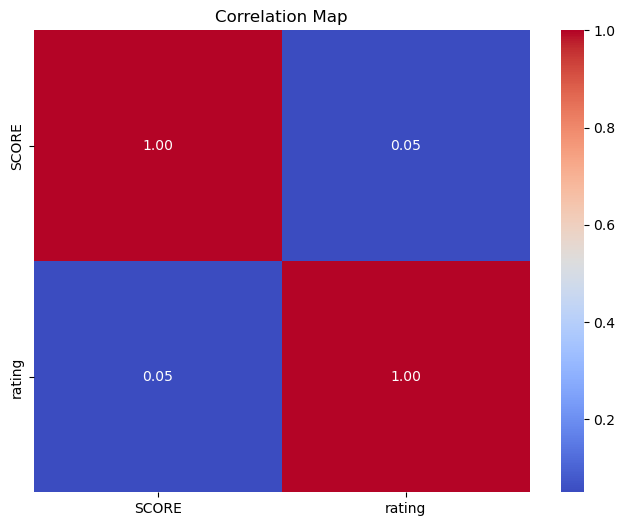

In [22]:
numeric_columns = ['SCORE', 'rating']

mdf_numeric = merged_df[numeric_columns].apply(pd.to_numeric, errors='coerce').dropna()

c_matrix = mdf_numeric.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Map')
plt.show()

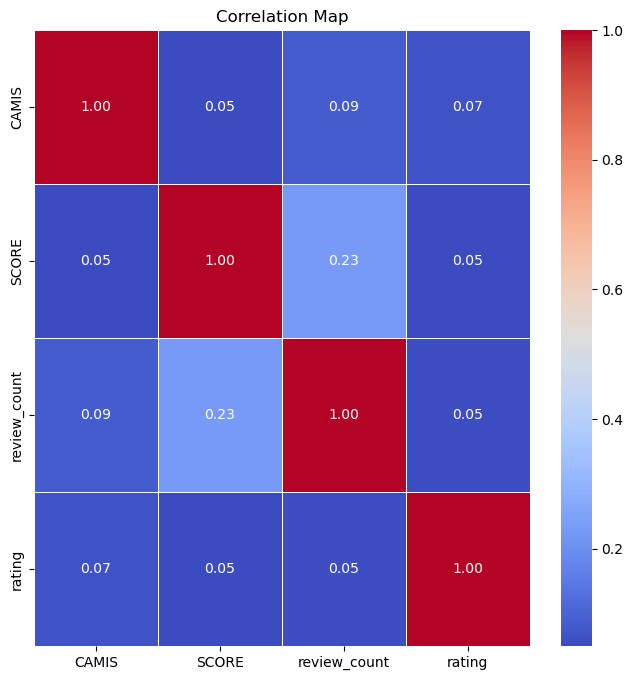

In [23]:
# Compute the correlation matrix
correlation_matrix = merged_df.corr()

# Plot the correlation heatmap using seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Map')
plt.show()

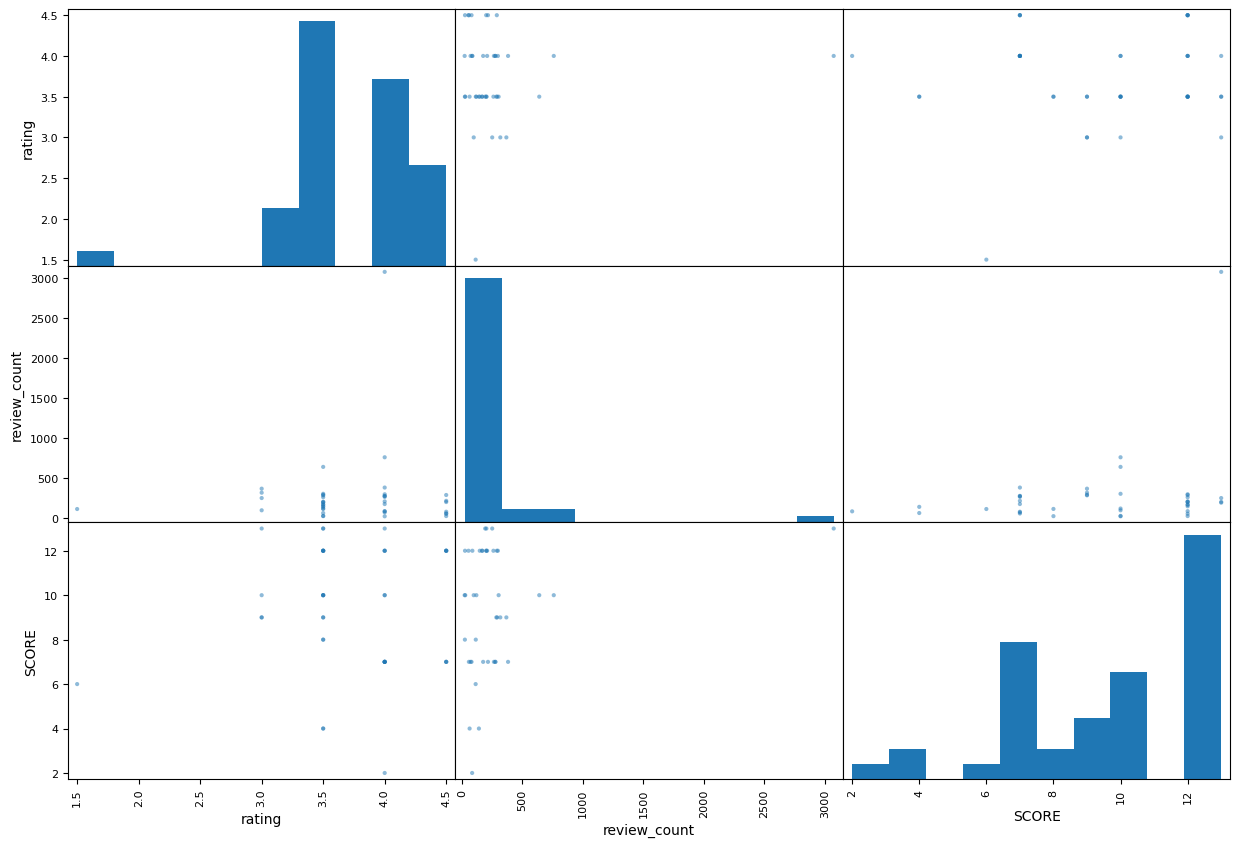

In [24]:
#creates a scatter plot matrix for recent_df
pd.plotting.scatter_matrix(merged_df[['rating','review_count', 'SCORE']], 
                           figsize=(15, 10));

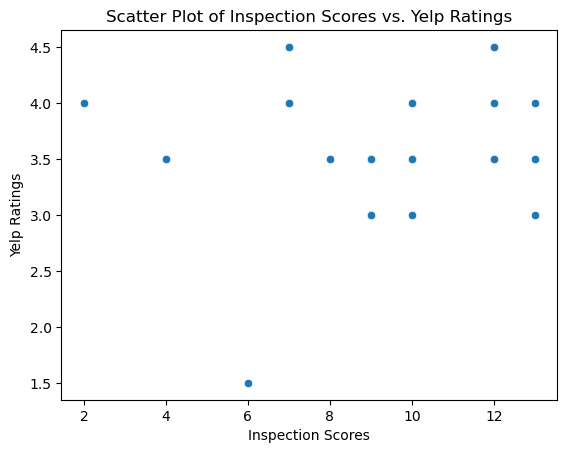

In [25]:
# Visualizing the correlation between Inspection scores and Yelp Ratings
sns.scatterplot(x=merged_df['SCORE'], y=merged_df['rating'])
plt.title('Scatter Plot of Inspection Scores vs. Yelp Ratings')
plt.xlabel('Inspection Scores')
plt.ylabel('Yelp Ratings')
plt.show()

## **Hypothesis Test 2:Try to find correlation between the inspection grades and the ratings on Yelp data**

## **Consider instead trying to find correlation between amount of reviews and ratings on Yelp data**

In [26]:
# Remove rows with 'N', 'Z', and 'P' in the 'GRADE' column
# These letters signify: N = Not Yet Graded, Z = Grade Pending,
# P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure
#merged_df = merged_df[~merged_df['GRADE'].isin(['N', 'Z', 'P'])]

In [27]:
merged_df['rating'].value_counts()

3.5    17
4.0    13
4.5     7
3.0     4
1.5     1
Name: rating, dtype: int64

In [28]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 488 to 369
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  42 non-null     int64  
 1   DBA                    42 non-null     object 
 2   BORO                   42 non-null     object 
 3   STREET                 42 non-null     object 
 4   CUISINE DESCRIPTION    42 non-null     object 
 5   INSPECTION DATE        42 non-null     object 
 6   ACTION                 42 non-null     object 
 7   VIOLATION CODE         42 non-null     object 
 8   VIOLATION DESCRIPTION  42 non-null     object 
 9   SCORE                  42 non-null     float64
 10  GRADE DATE             42 non-null     object 
 11  INSPECTION TYPE        42 non-null     object 
 12  name                   42 non-null     object 
 13  image_url              42 non-null     object 
 14  review_count           42 non-null     int64  
 15  ratin

In [29]:
print("Number of non-null values in 'rating':", merged_df['rating'].count())

Number of non-null values in 'rating': 42


In [30]:
# review_count_counts = merged_df['review_count'].value_counts().sort_values(ascending=False)
print(merged_df['review_count'])

488      79
66      284
323     192
163      97
331     167
458     275
68      202
31       25
260     175
74      303
463      57
341     381
267     639
154    3074
491      86
59      208
482     140
450     114
213      84
237      24
46      288
7       264
461     291
507     119
455     260
494      27
353     215
129     317
141     759
375      54
333     167
467     277
327      71
69      202
9       297
2       250
16      367
445      63
487     200
222     147
299      22
369     113
Name: review_count, dtype: int64


In [31]:
review_count = merged_df['review_count']
rating = merged_df['rating']

# Calculate IQR
Q1 = review_count.quantile(0.25)
Q3 = review_count.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (review_count < Q1 - 1.5 * IQR) | (review_count > Q3 + 1.5 * IQR)

# Print outliers
print("Outliers:")
print(merged_df[outliers])

Outliers:
        CAMIS                DBA      BORO          STREET  \
267  41393052          IGNAZIO'S  Brooklyn    WATER STREET   
154  50037645        JOE'S PIZZA  Brooklyn  BEDFORD AVENUE   
141  41250435  VINNIE'S PIZZERIA  Brooklyn  BEDFORD AVENUE   

    CUISINE DESCRIPTION INSPECTION DATE  \
267               Pizza      05/08/2023   
154               Pizza      05/08/2023   
141               Pizza      08/23/2022   

                                              ACTION VIOLATION CODE  \
267  Violations were cited in the following area(s).            10F   
154  Violations were cited in the following area(s).            06D   
141  Violations were cited in the following area(s).            08A   

                                 VIOLATION DESCRIPTION  SCORE  GRADE DATE  \
267  Non-food contact surface or equipment made of ...   10.0  05/08/2023   
154  Food contact surface not properly washed, rins...   13.0  05/08/2023   
141  Establishment is not free of harborage or cond.

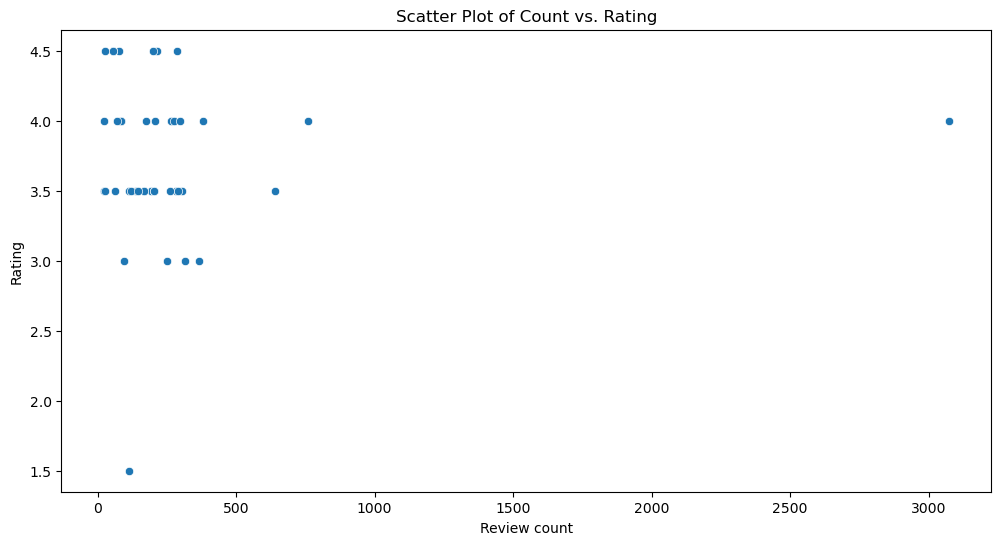

In [32]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='review_count', y='rating', data=merged_df)
plt.title('Scatter Plot of Count vs. Rating')
plt.xlabel('Review count')
plt.ylabel('Rating')
plt.show()

In [33]:
# Drop rows with NaN values if needed
original_length = len(merged_df)
merged_df = merged_df.dropna(subset=['review_count', 'rating'])
new_length = len(merged_df)

print(f'Original length: {original_length}')
print(f'New length after dropping NaN values: {new_length}')


# Convert 'rating' column to numeric
merged_df['rating'] = pd.to_numeric(merged_df['rating'], errors='coerce')

# Replace infinite values with NaN and drop rows with NaN values in the 'rating' column
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(subset=['rating'], inplace=True)

# Perform Pearson correlation test
if len(merged_df['review_count']) < 2 or len(merged_df['rating']) < 2:
    print("Not enough data points to perform the correlation test.")
else:
    # Perform Pearson correlation test
    correlation, p_value = pearsonr(merged_df['review_count'], merged_df['rating'])

    # Print results
    print(f'Correlation: {correlation:.2f}')
    print(f'P-value: {p_value:.4f}')

    # Check for significance based on the p-value
    if p_value < 0.05:
        print('The correlation is statistically significant.')
    else:
        print('There is no significant correlation.')

Original length: 42
New length after dropping NaN values: 42
Correlation: 0.05
P-value: 0.7323
There is no significant correlation.


## **Feature Engineering**

- Find out if there is a significant correlation between certain violations for certain restaurant types of specific areas/boros.

- Most common violations for each restaurant type and each set of chains if applicable for each boro.

- Do corporate restaurants or privately owned places get better scores/grades? What are the most common violations that cost the most points on the inspections.

- Construct predictive models to predict when initial and re-inspections are going to happen

- Construct predictive models to predict which restaurants will pass/fail inspections.

- Find out if there is correlation between a higher score/grade causing a restaurant to recive an overall better score on yelp. Look at the comparison between the results for coporate and privately owned places.